In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from scipy.stats import poisson

In [78]:
from scipy.stats import binom

In [4]:
lam = 1.4
dist = poisson(lam)
type(dist)

scipy.stats._distn_infrastructure.rv_discrete_frozen

In [5]:
k = 4
dist.pmf(k)

np.float64(0.039471954028253146)

In [6]:
from empiricaldist import Pmf

In [7]:
def make_poisson_pmf(lam, qs):
    """Make a Pmf of a Poisson distribution"""
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [8]:
goals = np.arange(10)
pmf_goals = make_poisson_pmf(lam, goals)

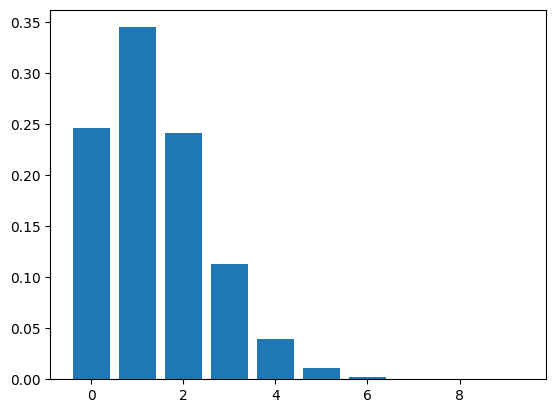

In [9]:
pmf_goals.bar()

In [10]:
from scipy.stats import gamma

In [11]:
alpha = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs)

In [12]:
prior = Pmf(ps, qs)
prior.normalize()

np.float64(9.889360237140306)

<Axes: title={'center': 'Prior Distribution of Lambda'}, xlabel='Goal scoring rate (lam)', ylabel='PMF'>

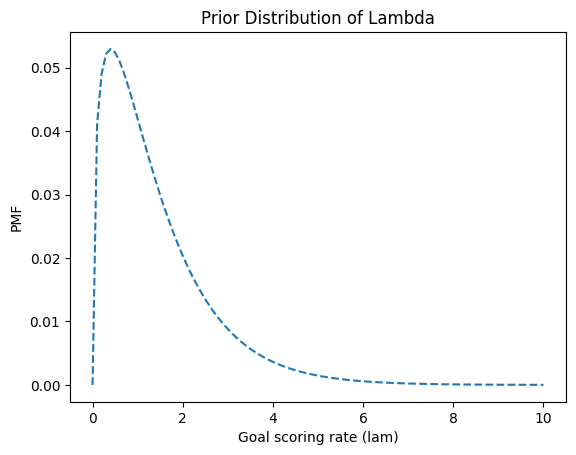

In [13]:
prior.plot(xlabel="Goal scoring rate (lam)", ylabel="PMF", title="Prior Distribution of Lambda", linestyle="--")

In [14]:
poisson(lam).pmf(4)

np.float64(0.039471954028253146)

In [ ]:
lams = prior.qs
k = 4
likelihood = poisson(lams).pmf(k)

In [15]:
def update_poisson(pmf, data):
    """Update PMF with a Poisson likelihood"""
    k = data
    lams = prior.qs
    likelihood = poisson(lams).pmf(k)
    pmf *= likelihood
    pmf.normalize()

In [16]:
france = prior.copy()
update_poisson(france, 4)

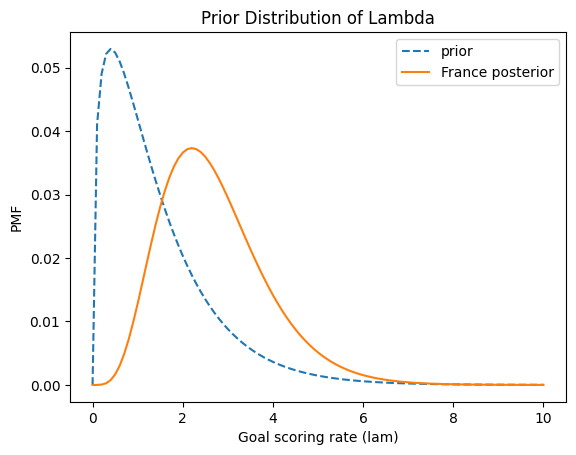

In [17]:
prior.plot(label="prior", xlabel="Goal scoring rate (lam)", ylabel="PMF", title="Prior Distribution of Lambda", linestyle="--")
france.plot(label="France posterior")
plt.legend()

In [18]:
croatia = prior.copy()

In [19]:
update_poisson(croatia, 2)

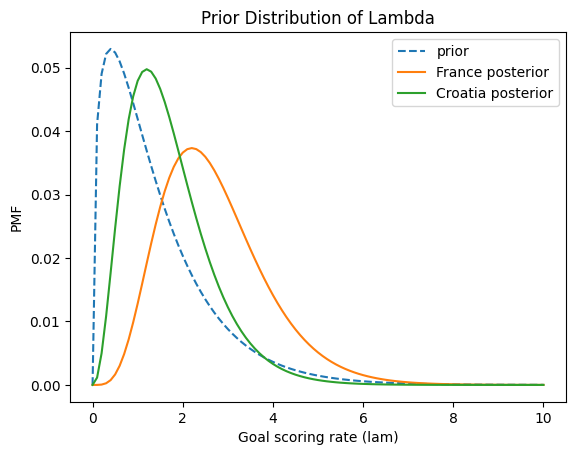

In [20]:
prior.plot(label="prior", xlabel="Goal scoring rate (lam)", ylabel="PMF", title="Prior Distribution of Lambda", linestyle="--")
france.plot(label="France posterior")
croatia.plot(label="Croatia posterior")
plt.legend()

In [21]:
print(france.mean(), croatia.mean())

2.699772393342308 1.6999765866755225


In [22]:
# probability of superiority

def prob_gt(pmf1, pmf2):
    total = 0
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            if q1 > q2:
                total += p1 * p2
    return total

In [23]:
prob_gt(france, croatia) # can also be done with Pmf.prob_gt(france, croatia)

0.7499366290930155

In [24]:
# Predicting a rematch

pmf_seq = [make_poisson_pmf(lam, goals) for lam in prior.qs]

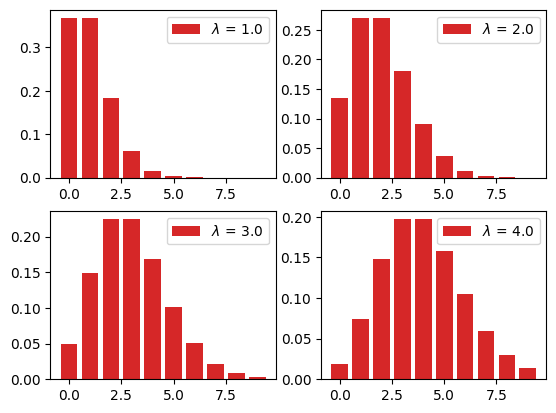

In [26]:
for i, index in enumerate([10, 20, 30, 40]):
    plt.subplot(2, 2, i+1)
    lam = prior.qs[index]
    pmf = pmf_seq[index]
    pmf.bar(label=f'$\lambda$ = {lam}', color='C3')
    plt.legend()

In [27]:
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

In [28]:
pred_france = make_mixture(france, pmf_seq)

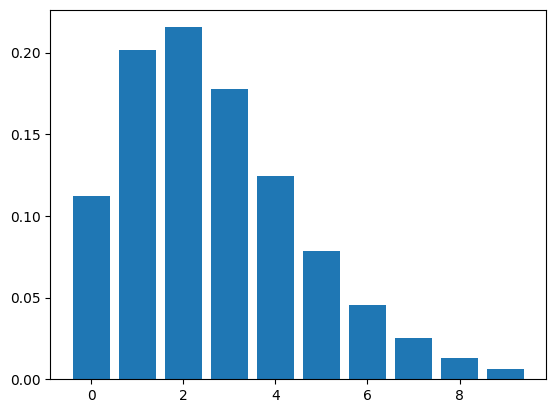

In [29]:
pred_france.bar()

In [30]:
pred_croatia = make_mixture(croatia, pmf_seq)

In [31]:
win_f = Pmf.prob_gt(pred_france, pred_croatia)
lose_f = Pmf.prob_lt(pred_france, pred_croatia)
draw = Pmf.prob_eq(pred_france, pred_croatia)

In [32]:
win_f

np.float64(0.5703522415934519)

In [33]:
lose_f

np.float64(0.26443376257235873)

In [34]:
draw

np.float64(0.16521399583418947)

In [36]:
win_f + draw/2

np.float64(0.6529592395105466)

In [37]:
def expo_pdf(t, lam):
    return lam * np.exp(-lam * t)

In [38]:
lam = 1.4
qs = np.linspace(0, 4, 101)
ps = expo_pdf(qs, lam)
pmf_time = Pmf(ps, qs)
pmf_time.normalize()

np.float64(25.616650745459093)

<Axes: title={'center': 'Distribution of time between goals'}, xlabel='Time between goals', ylabel='PMF'>

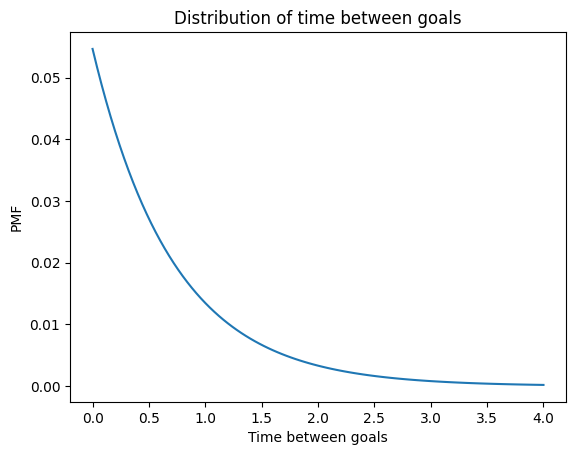

In [40]:
pmf_time.plot(xlabel="Time between goals", ylabel="PMF", title="Distribution of time between goals")

In [41]:
# Exercise 8-1
# This is a tough one, and not easy to follow the intuition based on what's presented in the chapter
# IF I FOLLOW:
# The gamma is the prior distribution for the goal-scoring rate
# The exponential is a pdf, but can be used as a likelihood in a Bayesian analysis

# The solution starts by giving a function that updates the distribution of lam with the given time b/w goals

def update_expo(pmf, data):
    """Update based on an observed interval
       PMF: the prior PMF
       data: time between goals (min)"""
    t = data / 90
    lams = pmf.qs
    likelihood = expo_pdf(t, lams)
    pmf *= likelihood
    pmf.normalize()

In [42]:
# Here's the solution updating the given gamma prior (the distribution of lam) for the first and second Germany goals

alpha = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs)
prior = Pmf(ps, qs)
prior.normalize()

np.float64(9.889360237140306)

In [43]:
# This creates a posterior for the expected value of lambda after Germany scores at minute 11
# So, multiplying the gamma prior by the exponential likelihood

germany = prior.copy()
update_expo(germany, 11)

In [44]:
# This updates the posterior for expected lambda, accounting for Germany goals at mins 11 and 23

germany2 = germany.copy()
update_expo(germany2, 12)

In [45]:
# Values of lambda after the first 2 Germany goals

germany.mean(), germany2.mean()

(np.float64(2.1358882653086892), np.float64(2.703059034926364))

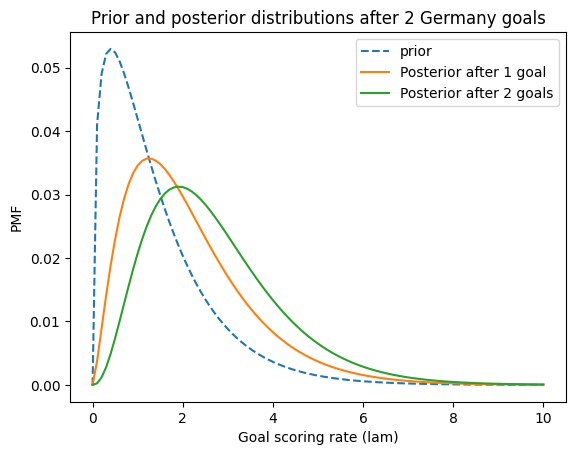

In [47]:
prior.plot(title="Prior and posterior distributions after 2 Germany goals", ls="--", label="prior")
germany.plot(label="Posterior after 1 goal", xlabel="Goal scoring rate (lam)", ylabel="PMF")
germany2.plot(label="Posterior after 2 goals")
plt.legend()

In [48]:
# The solution then estimates a posterior predictive distribution for all values of lam in the remaining 90-23 minutes
# This is basically just like the predicted posterior given in the text, except that lam*t is an argument to make_poisson_pmf rather than lam

t = (90 - 23) / 90
pmf_seq = [make_poisson_pmf(lam*t, goals) for lam in germany2.qs]

In [49]:
# And then a mixture of predictive distributions, weighted by the probabilities in the posterior
# make_mixture takes a pmf mapping each hypothesis to a probability, and a sequence of pmfs (1 per hypothesis)

pred_germany2 = make_mixture(germany2, pmf_seq)

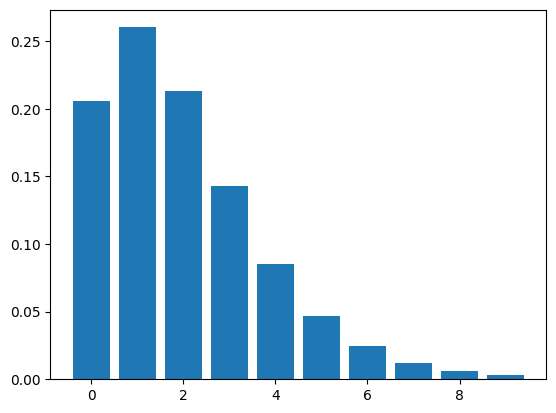

In [51]:
pred_germany2.bar()

In [52]:
# Probability of scoring 5 more goals after minute 23

pred_germany2[5]

np.float64(0.047109658706113416)

In [53]:
# Probability of at least 5
pred_germany2.prob_ge(5)

np.float64(0.09286200122834538)

In [54]:
# Exercise 8-2 - return to original WC problem, in a rematch between FRA and CRO, prob that FRA scores first

# The solution starts with a function that creates a PMF approximating an exponential distribution
# This can be somewhat inferred from the main text, estimating a distribution of time between goals

def make_expo_pmf(lam, high):
    """Makes a PMF of an exponential
       lam = event rate
       high = upper bound on interval 't'
       returns a PMF of the interval between events"""
    qs = np.linspace(0, high, 101)
    ps = expo_pdf(qs, lam)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [55]:
# Then it calculates the predictive distributions for the time till the first goal, the sequence of pmfs needed as the second input to make_mixture
# It is not clear why "high" is given the input 4. In the text it's a max for the number of games it takes to score a goal. So maybe arbitrary.

pmf_seq = [make_expo_pmf(lam, high=4) for lam in prior.qs]

In [56]:
# Then the solution calculates posterior predicted distributions as mixtures based on each team's posterior

pred_france = make_mixture(france, pmf_seq)
pred_croatia = make_mixture(croatia, pmf_seq)

In [57]:
# The probability that France scores first
Pmf.prob_lt(pred_france, pred_croatia)

np.float64(0.5904596116867543)

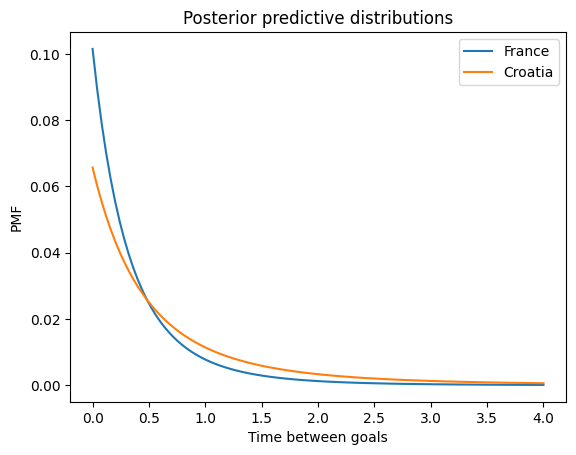

In [59]:
pred_france.plot(label="France", title="Posterior predictive distributions")
pred_croatia.plot(label="Croatia", xlabel="Time between goals", ylabel="PMF")
plt.legend()

In [79]:
# Exercise 8-3

# Boston loses game 1 0-1 and game 2 2-3
# Boston wins game 3 8-1 and game 4 4-0
# Prob that Boston wins game 5?
# Probability that Boston wins 2 of the next 3 games?

# Prior is a gamma distribution assuming 2.8 goals per game for each team

alpha = 2.8
qs = np.linspace(0, 10, 101) # The upper bound in the solution is 15, which may be more realistic for hockey
ps = gamma(alpha).pdf(qs)
prior = Pmf(ps, qs)
prior.normalize()

# Update based on Game 1

bos1 = prior.copy()
update_poisson(bos1, 0)

van1 = prior.copy()
update_poisson(van1, 1)

# Update based on Game 2

bos2 = bos1.copy()
update_poisson(bos2, 2)
van2 = van1.copy()
update_poisson(van2, 3)

# Update based on Game 3

bos3 = bos2.copy()
update_poisson(bos3, 8)
van3 = van2.copy()
update_poisson(van3, 1)

# Update based on Game 4

bos4 = bos3.copy()
update_poisson(bos4, 4)
van4 = van3.copy()
update_poisson(van4, 0)

# Game 5

goals = np.arange(15) # From the solution
pmf_seq = [make_poisson_pmf(lam, goals) for lam in bos4.qs]

pred5_bos = make_mixture(bos4, pmf_seq)
pred5_van = make_mixture(van4, pmf_seq)

win5_bos = Pmf.prob_gt(pred5_bos, pred5_van)
win5_bos # Estimated as 0.7038631 - YES!!!

tie = Pmf.prob_eq(pred5_bos, pred5_van)
win5_bos_wt = win5_bos + tie / 2
win5_bos_wt # YES!!!

# Probability of Boston winning the series = Pr Boston wins 5 and 6, or 6 and 7, or 5 and 7

# We don't know the number of goals that would be scored in game 5 or 6, so we can't update the posteriors
# The solution offers a very simply binomial analysis

n = 3
b = binom.pmf([2, 3], n, win5_bos_wt)
b.sum()

np.float64(0.8670900107227688)

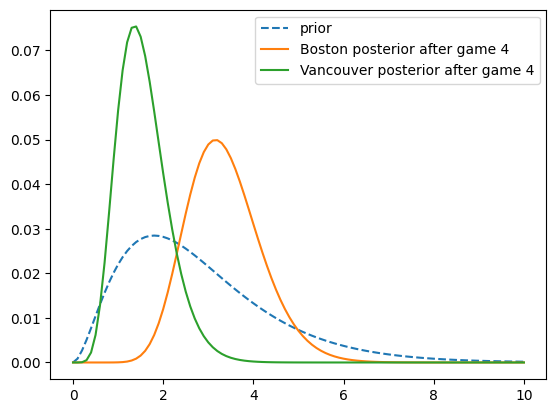

In [74]:
prior.plot(ls="--", label="prior")
#bos1.plot(label="Boston posterior after game 1")
#van1.plot(label="Vancouver posterior after game 1")
#bos2.plot(label="Boston posterior after game 2")
#van2.plot(label="Vancouver posterior after game 2")
bos4.plot(label="Boston posterior after game 4")
van4.plot(label="Vancouver posterior after game 4")
plt.legend()